In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE,accuracy_score, confusion_matrix,ConfusionMatrixDisplay,f1_score,accuracy_score,recall_score,roc_auc_score,classification_report,precision_score
from imblearn.over_sampling import SMOTE
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import randint

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

In [78]:
print("Nice")

Nice


In [79]:
df = pd.read_csv("data/stroke.csv")
copy = df
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [80]:
df["gender"].unique()

array(['Male', 'Female', 'Other'], dtype=object)

# Xử lý dữ liệu (chưa cân bằng dataset)

In [81]:
df.fillna(df['bmi'].median(),inplace = True)

In [82]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [83]:
df["gender"].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [84]:
df = df[df['gender'] != 'Other']

In [85]:
df["gender"].unique()

array(['Male', 'Female'], dtype=object)

In [86]:
df.drop('id', axis=1, inplace=True)

/var/folders/nl/_hr7lj355xl4gxtqkyg3jv5m0000gp/T/ipykernel_4828/48924119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('id', axis=1, inplace=True)


In [87]:
categorical_variables = ['gender', 'ever_married','work_type', 'Residence_type','smoking_status']

In [88]:
LE=LabelEncoder()

In [89]:
for variable in categorical_variables:
     df[variable] = LE.fit_transform(df[variable].astype(str))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   int64  
 6   Residence_type     5109 non-null   int64  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   int64  
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 479.0 KB
None


/var/folders/nl/_hr7lj355xl4gxtqkyg3jv5m0000gp/T/ipykernel_4828/2814796947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = LE.fit_transform(df[variable].astype(str))
/var/folders/nl/_hr7lj355xl4gxtqkyg3jv5m0000gp/T/ipykernel_4828/2814796947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable] = LE.fit_transform(df[variable].astype(str))
/var/folders/nl/_hr7lj355xl4gxtqkyg3jv5m0000gp/T/ipykernel_4828/2814796947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [90]:
X = df.loc[:, df.columns != 'stroke']
y = df.loc[:, df.columns == 'stroke']

In [91]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,2,1,228.69,36.6,1
1,0,61.0,0,0,1,3,0,202.21,28.1,2
2,1,80.0,0,1,1,2,0,105.92,32.5,2
3,0,49.0,0,0,1,2,1,171.23,34.4,3
4,0,79.0,1,0,1,3,0,174.12,24.0,2


# Graph 1: Xem correlation 

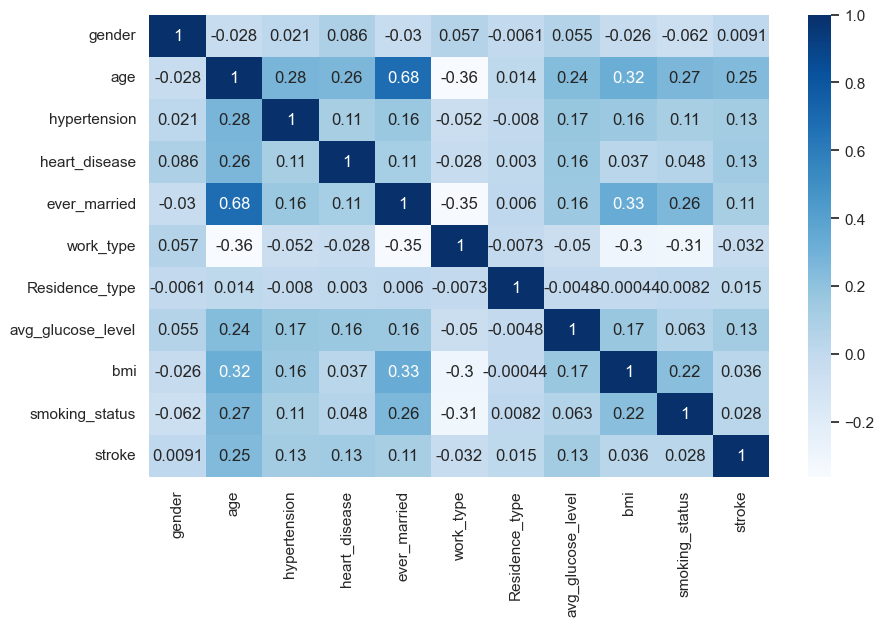

In [92]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(),annot= True,cmap='Blues');
plt.show()

Từ cái heatmap thấy là age, glucose level, hypertension, heart disease,ever married có correlate với stroke, mấy cái khác thì không đáng kể.

# Graph 2: glucose level với stroke

/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

<Axes: xlabel='age', ylabel='avg_glucose_level'>

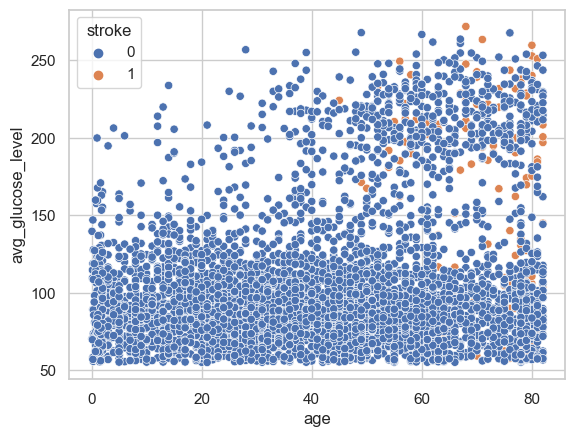

In [93]:
sns.scatterplot(x='age', y='avg_glucose_level',hue='stroke',data=df)

Ta thấy có hai clusters, ở dưới là toàn người không có stroke trong khi ở trên là ngươi có hoặc không có stroke. Từ dây, ta suy luận rằng những người không có stroke là những người có glucose_level thấp

# Graph 3: HyperTension với Stroke

/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='stroke', ylabel='count'>

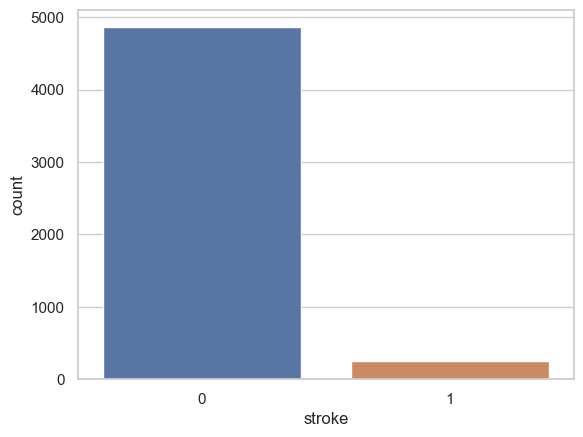

In [94]:
sns.countplot(x='stroke', data = df)

Ta thấy là dataset của chúng ta hiện đang imbalance, do đó trước khi đi phân tích correlation giữa hypertension và stroke thì ta phải làm dataset cân bằng. Mình sẽ chọn undersample (nên làm cả hai trường hợp luôn, nhưng mà thử display oversample thì nó hơi sai sự thật, chắc là do thông tin được thêm vào synthetic nên vậy, thế là dùng undersample)

In [95]:
# Class count
count_class_0, count_class_1 = df['stroke'].value_counts()
# Divide by class
df_class_0 = df[df['stroke'] == 0]
df_class_1 = df[df['stroke'] == 1]

Random under-sampling:
stroke
0    249
1    249
Name: count, dtype: int64


/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='stroke', ylabel='count'>

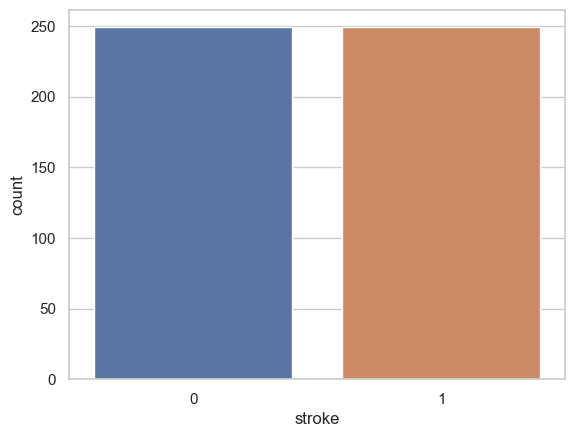

In [96]:
# Because our data is imbalance, we will randomly undersample our data
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['stroke'].value_counts())

sns.countplot(x='stroke',data= df_test_under)

/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

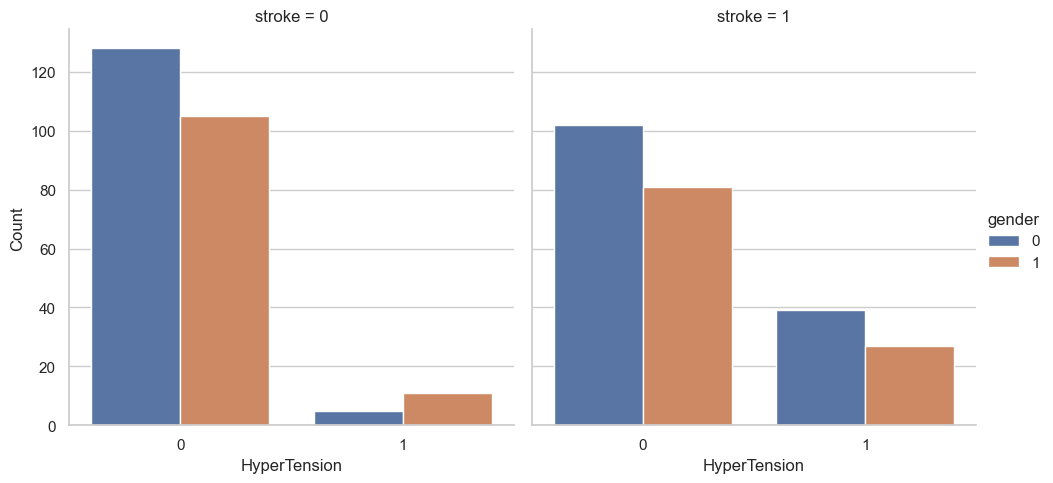

In [97]:
sns.set(style='whitegrid')  # Optional: Set the style
copy = copy[copy["gender"] != 'Other']
g = sns.catplot(x='hypertension', hue='gender', col='stroke',
                data=df_test_under, kind='count')
g.set_axis_labels('HyperTension', 'Count')

Sau khi đã balance data bằng undersample rồi, ta đi phân tích. Quan sát rằng, những người có hypertertion bị stroke nhiều hơn là không bị stroke. Cùng lúc đó, nhưng người không có hypertension ít bị stroke hơn là bị stroke. Từ đây suy ra hypertension có ảnh hưởng đến dự đoán stroke (ghi mà hoa cả mắt :> ). Ta không thấy sự khác nhau quá nhiều giữa hai giới tính -> giới tính có thể không ảnh hưởng đến chuẩn đoán stroke.

# Graph 5: Dùng PCA + Logistic Regression

Hiện giờ chúng ta có 7 variables -> vẫn quá lớn nên dễ overfitting. Vậy mình dùng PCA nhé.

In [98]:
# Ta đi normalize data trước khi apply PCA
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Select numerical columns to scale
numerical_cols_to_scale = ['age', 'avg_glucose_level', 'bmi']

X_under = df_test_under.loc[:, df.columns != 'stroke']
y_under = df_test_under.loc[:, df.columns == 'stroke']

# Apply scaling on numerical columns
X_under[numerical_cols_to_scale] = scaler.fit_transform(X_under[numerical_cols_to_scale])

# Display the first few rows of the dataframe to verify scaling
X_under.head()

/var/folders/nl/_hr7lj355xl4gxtqkyg3jv5m0000gp/T/ipykernel_4828/3845265314.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_under[numerical_cols_to_scale] = scaler.fit_transform(X_under[numerical_cols_to_scale])


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
2543,0,-1.845428,0,0,0,4,0,-0.734001,-1.219322,0
2146,1,-1.845428,0,0,0,4,0,-0.177143,-1.814070,2
950,1,-1.756470,0,0,0,2,1,-1.088776,1.891667,0
3945,0,0.912264,0,1,1,3,1,-0.619481,-0.182326,3
753,0,-2.372058,0,0,0,4,1,-1.033778,-1.844570,0


In [99]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_under)

array([[ 3.34654188,  0.46695757, -0.48319811, ...,  0.07804208,
         0.15071185,  0.05513952],
       [ 2.59663915, -0.33804754, -1.27514851, ...,  0.07643036,
         0.22649558, -0.17807885],
       [ 1.18803137, -0.31456961, -0.40096171, ...,  0.36639408,
         0.34073266, -0.03285434],
       ...,
       [ 0.35193132,  0.23757646,  0.15337755, ..., -0.29895387,
         0.08632203, -0.05706748],
       [ 0.81760164,  1.06243242,  0.46060475, ...,  0.55229018,
        -0.50915416, -0.02376886],
       [ 0.9077115 ,  0.73878733,  1.91950477, ..., -0.27615213,
        -0.03379826, -0.05027439]])

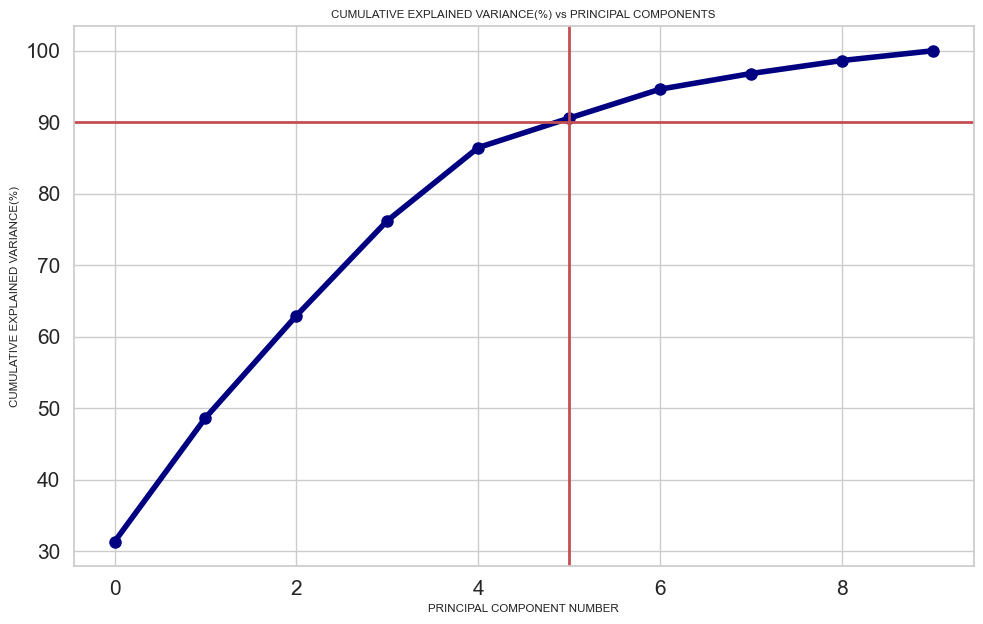

In [100]:
# Vẽ bảng cumulative variance
fig = plt.figure(figsize=(10,6))

axes = fig.add_axes([0.1,0.1,0.9,0.9])
axes.tick_params(axis='x', labelsize= 15 )
axes.tick_params(axis='y', labelsize= 15 )
axes.set_title('CUMULATIVE EXPLAINED VARIANCE(%) vs PRINCIPAL COMPONENTS',fontsize='x-small')
axes.set_ylabel('CUMULATIVE EXPLAINED VARIANCE(%)',fontsize='x-small')
axes.set_xlabel('PRINCIPAL COMPONENT NUMBER',fontsize='x-small')
axes.plot(np.cumsum(pca.explained_variance_ratio_)*100,color='navy',lw =4, ls='-', marker='o', markersize='8')
plt.axhline(90,color='r',lw = 2)
plt.axvline(5,color='r',lw = 2)
plt.show();

Như ta thấy thì 5 variables accounts cho 90% rồi. Vì vậy chúng ta quyết định sẽ dùng 5 features để dùng linear regression 

In [101]:
pca = PCA(n_components = 5)
pca.fit_transform(X_under)

array([[ 3.34654188,  0.46695757, -0.48319811,  0.08569294,  0.08806471],
       [ 2.59663915, -0.33804754, -1.27514851, -1.33112132,  0.96504767],
       [ 1.18803137, -0.31456961, -0.40096171,  2.98480121, -0.18958561],
       ...,
       [ 0.35193132,  0.23757646,  0.15337755, -0.30160967, -1.44219668],
       [ 0.81760164,  1.06243242,  0.46060475,  0.01950197, -1.41780655],
       [ 0.9077115 ,  0.73878733,  1.91950477, -0.67012862, -0.83439351]])

In [102]:
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, train_size = 0.8, random_state = 20, stratify = y_under)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
y_train = y_train.values.ravel()

lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)

LogisticRegression()

In [103]:
y_pred = lr.predict(X_test_reduced)

In [104]:
score = MSE(y_test, y_pred)
RMSE = (score)*(1/2)
accuracy = accuracy_score(y_test, y_pred)

summary = pd.DataFrame({
    "RMSE": [RMSE],
    "Accuracy": [accuracy]
})
summary.head()

,RMSE,Accuracy
0,0.095,0.81


# -> Tổng kết: dùng PCA + Logistic Regression cho RMSE 0.105, Acc: 0.81


# Dùng Regularization + Logistic Regression 

In [105]:
# Specify L1 regularization
lr = LogisticRegression(solver='liblinear', penalty='l1',random_state=42)

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10,100]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 0.1}
Total number of features: 10
Number of selected features: 3


In [106]:
y_pred = best_lr.predict(X_test)

In [107]:
score = MSE(y_test, y_pred)
RMSE = (score)*(1/2)
print(f"RMSE: {RMSE}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

RMSE: 0.105
Accuracy: 0.79


In [108]:
summary = pd.DataFrame({
    "RMSE": [RMSE],
    "Accuracy": [accuracy]
})
summary.head()

,RMSE,Accuracy
0,0.105,0.79


# Tổng kết: Regularization + Logistic Regression có RMSE: 0.1, Acc: 0.79

# Graph 6

In [109]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

In [110]:
y_over.head()

,stroke
0,1
1,1
2,1
3,1
4,1


SMOTE over-sampling:
stroke
1    4860
0    4860
Name: count, dtype: int64


/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tranvo1233/anaconda3/envs/sad/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='stroke', ylabel='count'>

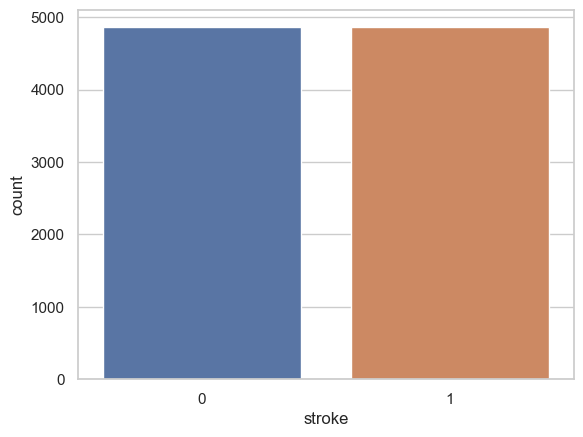

In [111]:
df_test_over = pd.concat([X_over, y_over], axis=1).reset_index()

print('SMOTE over-sampling:')
print(df_test_over['stroke'].value_counts())

sns.countplot(x='stroke',data= df_test_over)

In [112]:
df_test_over.head()

,index,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,1,0,61.0,0,0,1,3,0,202.21,28.1,2,1
2,2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,4,0,79.0,1,0,1,3,0,174.12,24.0,2,1


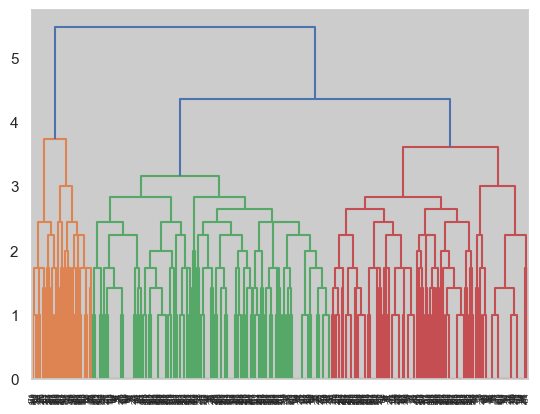

In [113]:
# Import the linkage, dendrogram functions
from scipy.cluster.hierarchy import linkage, dendrogram

# Use the linkage() function
distance_matrix = linkage(df_test_under[["gender", "hypertension","heart_disease","ever_married","work_type",
                                         "Residence_type","smoking_status","stroke"]], 
                          method = 'complete', metric = 'euclidean', )
dn = dendrogram(distance_matrix, p=10)

plt.show()

# Graph 7: Decision Tree

In [114]:
from sklearn.tree import DecisionTreeClassifier

In [115]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)


In [116]:
y_pred = clf.predict(X_test)

In [117]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.65


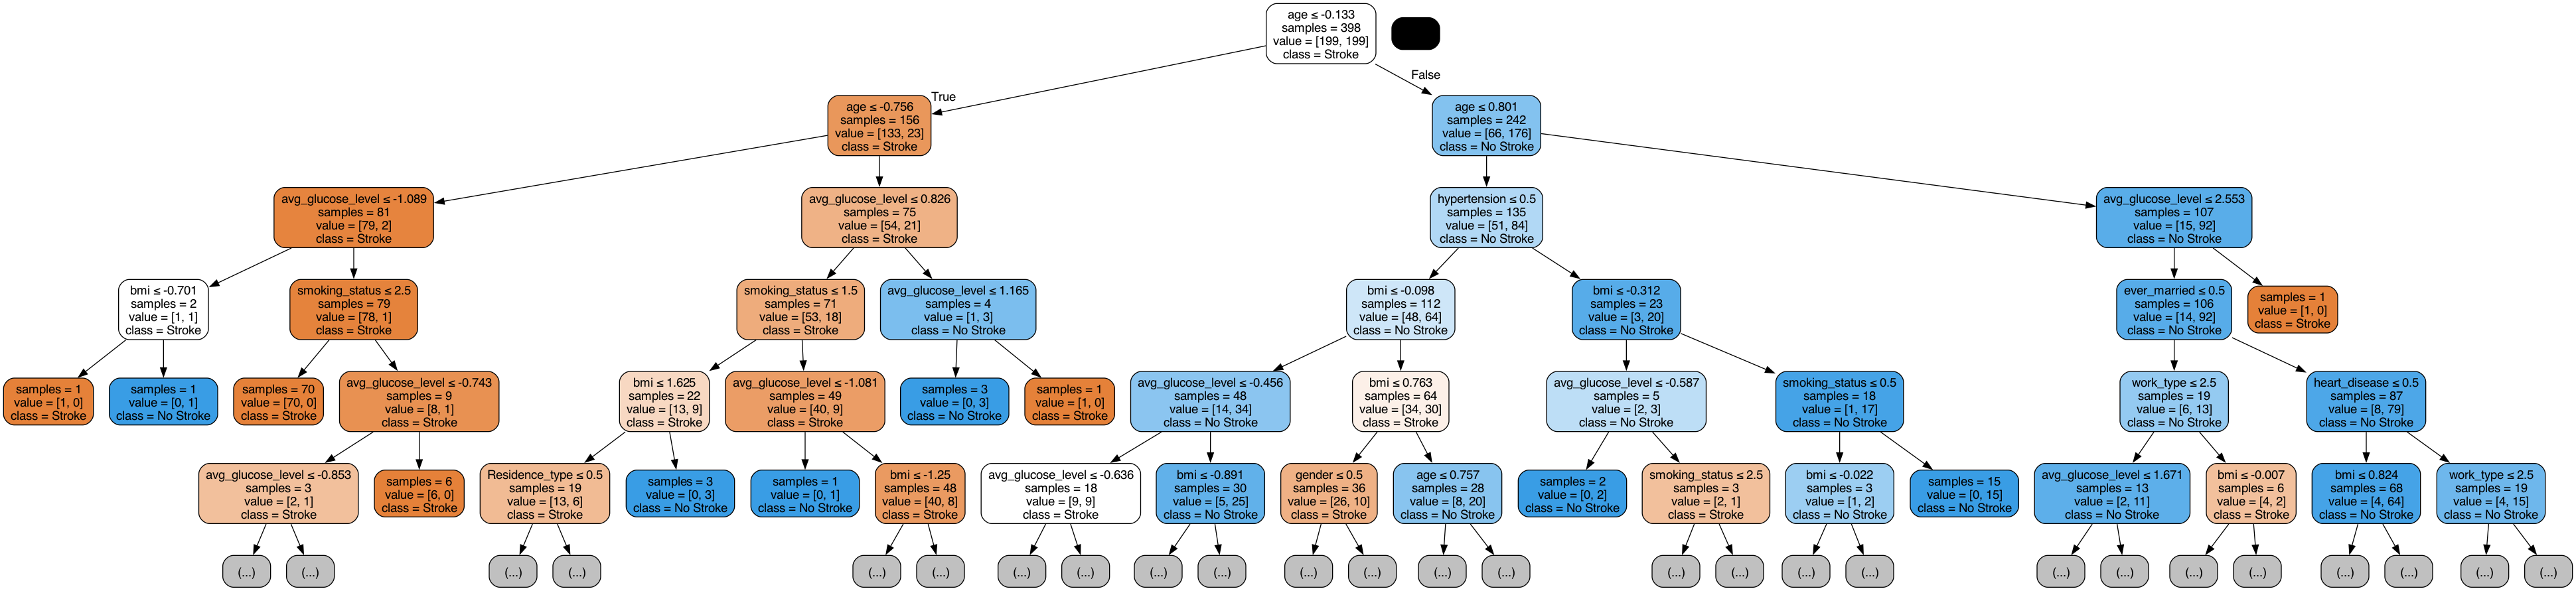

In [118]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = X.columns,
                max_depth=5,
                impurity=False, 
                class_names=['Stroke','No Stroke'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTreeClassifier.png')
Image(graph.create_png())


# Graph 8: Confusion Matrix cho Decision Tree

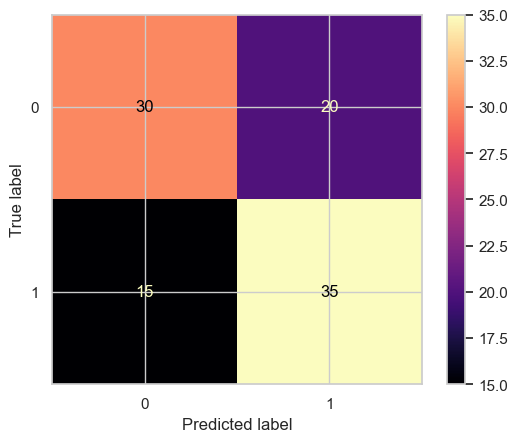

In [119]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cmap = plt.get_cmap('magma')

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=cmap)

In [120]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,classification_report,precision_score
# dt_f1 = f1_score(y_test, y_pred)
# dt_acc = accuracy_score(y_test, y_pred)
# dt_recall = recall_score(y_test, y_pred)
# dt_auc = roc_auc_score(y_test, y_pred)

In [121]:
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

              precision    recall  f1-score   support

           0       0.67      0.60      0.63        50
           1       0.64      0.70      0.67        50

    accuracy                           0.65       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.65      0.65      0.65       100

--------------------------------------------------------


# Tổng kết: Decion Tree có Acc là 90.91% (do oversample nen minh cung khong ro co anh huong gi khong nua TT)

In [122]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state =42,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [123]:
y_pred = rf.predict(X_test)

In [124]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.84


In [125]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names = X.columns,
                    max_depth=5,
                    impurity=False, 
                    class_names=['Stroke','No Stroke'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('RandomForestTree.png')
    Image(graph.create_png())

# Dung ensembler RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

RF_random_model = RandomForestClassifier()

RF_random__search_model  = RandomizedSearchCV(RF_random_model , 
                                 param_distributions = param_dist, 
                                random_state=42,
                                 n_iter=5, 
                                 cv=5)
RF_random__search_model.fit(X_train,y_train)

In [ ]:
RF_random_model = RF_random__search_model.best_estimator_

print('Best hyperparameters:',  RF_random__search_model.best_params_)

In [ ]:
y_pred = RF_random_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Graph 9: Feature Importances cua Random Forest Tree

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(RF_random_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
feature_importances.plot.barh(color='red',title="Feature Importances");

# Tong ket: Random Forest Tree dat 94.8% ? Tai sao lam ban rieng la 97% ma nhi? Khac la minh dung Label Encoding thay vi getDummies

# Dung GridSearchCV

In [ ]:
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

In [ ]:
RF_grid_model = RandomForestClassifier(random_state=101)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "recall", 
                             n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [ ]:
from termcolor import colored
print(colored('\033[1mBest Parameters of GridSearchCV for Random Forest Model:\033[0m', 'blue'), colored(RF_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Random Forest Model:\033[0m', 'blue'), colored(RF_grid_model.best_estimator_, 'cyan'))
                                                                                                        

# Graph 10: Confusion Matrix for RFT GridSearch

In [ ]:
y_pred = RF_grid_model.predict(X_test)
y_train_pred = RF_grid_model.predict(X_train)

rf_grid_f1 = f1_score(y_test, y_pred)
rf_grid_acc = accuracy_score(y_test, y_pred)
rf_grid_recall = recall_score(y_test, y_pred)
rf_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")


cm = confusion_matrix(y_test, y_pred)
cmap = plt.get_cmap('magma')

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=cmap)

In [ ]:
print(rf_grid_acc)

# Save model

In [ ]:
import pickle

In [ ]:
pickle.dump(
    RF_grid_model,  # Replace with your model
    open("RF_grid_model.pickle", "wb"),  # Specify where to save the model
)

In [ ]:
# Load a pickle file
RF_grid_model = pickle.load(
    open("RF_grid_model.pickle", "rb")  # Specify which file to load
)

RF_grid_model

In [ ]:
y_pred = RF_grid_model.predict(X_test)

In [ ]:
print(y_pred)
print(y_test["stroke"])

In [ ]:
pickle.dump(
    RF_random_model,  # Replace with your model
    open("RF_random_model.pickle", "wb"),  # Specify where to save the model
)

In [ ]:
# Load a pickle file
RF_random_model = pickle.load(
    open("RF_random_model.pickle", "rb")  # Specify which file to load
)

RF_random_model

In [ ]:
y_pred = RF_random_model.predict(X_test)

In [ ]:
print(y_pred)
print(y_test["stroke"])